In [1]:
import os
import pandas as pd
import env
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as wg
import explore as ex

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)
random_state = 77

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
alpha = .05

# Zillow: Finding drivers of Log Error

By: Daniel Ford

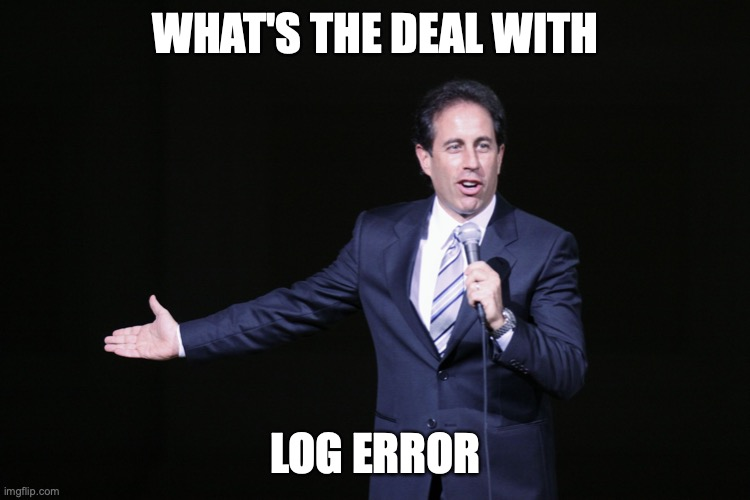

# Wrangle

## Acquire



In [2]:
df = wg.acquire()
df.shape

(52319, 68)

## Total observations collected: 52,319

In [3]:
df = wg.prepare(df)
df.shape

(51728, 21)

## Cleaning

- Drop nulls, and Duplicate values
- Dropped duplicate columns, id columns, and others not deemed significant
- Optimized data by converting select columns data types
- Filled missing values with 0 of:
    - fireplacecnt
    - garagecarcnt
    - garagetotalsqft
    - hashottuborspa
    - poolcnt
    - taxdelinquencyflag
    
## Total obsservations after cleaning: 51,728

__Note:__ As using standard methods to remove outliers removed roughly half of the observations, I didn't feel comfortable removing that data. this data contains outliers until a better method can be used to address the situation

In [4]:
#function to split the data
train, validate, test = wg.train_validate_test_split(df)

train	 n = 28967
test	 n = 10346
validate n = 12415


In [5]:
#Scaling the data - with more time this should be changed to robust scaler
train_scaled, validate_scaled, test_scaled = wg.MM_scale_zillow(train,validate,test)

In [6]:
#function to add clusters for visualization
ex.add_clusters(train_scaled, validate_scaled, test_scaled)
train_scaled.head()

,bathroomcnt,bedroomcnt,sq_ft,county,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxdelinquencyflag,logerror,propertylandusedesc,hot_tub_or_spa,age,taxval_sqft,cluster_BedBath,cluster_BedBathSqft,cluster_BedBathTaxvaluepersqft,cluster_LatLong
7677,0.4,0.363636,0.162172,LA County,0.0,0.4,0.0,0.000000,0.0,0.551620,0.461458,0.000749,0.0,0.053904,0.036677,1,0.003152,Single Family Residential,0,0.065217,0.067361,low,low,1,central
12608,0.1,0.272727,0.078980,LA County,0.0,0.1,0.0,0.000000,0.0,0.777917,0.444821,0.001746,0.0,0.039519,0.015908,0,0.004674,Single Family Residential,0,0.369565,0.056960,mid,mid,0,central
44211,0.1,0.272727,0.055461,LA County,0.0,0.1,0.0,0.000000,0.0,0.580396,0.497229,0.000930,0.0,0.029990,0.017907,0,-0.037723,Single Family Residential,0,0.485507,0.088089,mid,mid,0,central
44400,0.1,0.272727,0.077810,LA County,0.0,0.1,0.0,0.000000,0.0,0.343542,0.687752,0.000698,0.0,0.015154,0.020441,0,-0.014083,Single Family Residential,0,0.463768,0.074392,mid,mid,0,east
30257,0.2,0.363636,0.108348,Orange County,0.0,0.2,0.1,0.134436,0.0,0.300080,0.798239,0.001056,0.0,0.021640,0.017938,0,-0.096859,Single Family Residential,0,0.456522,0.047919,high,high,2,west


# Explore

## Correlations - Target: Log Error

### What is the distribution of Log error?

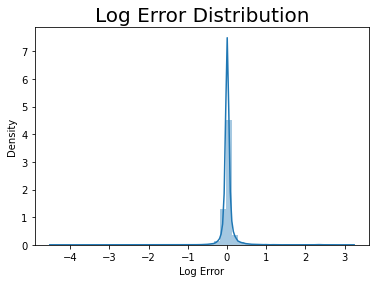

In [7]:
ex.LE_dist(train)

### What features have the highest correlation with _LogError_?

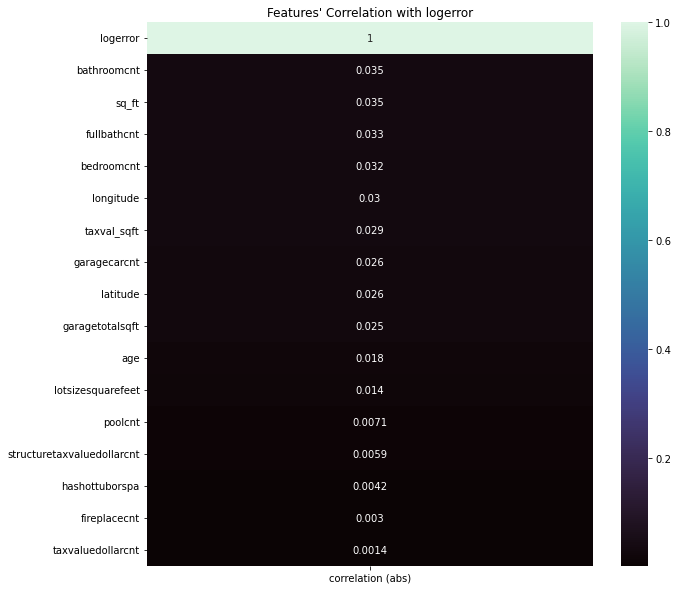

In [8]:
#value_corelations is a function to quickly visualize the correlations between logerror and other features
ex.value_correlations(train)

From this visualization I can tell that while there is no exceptional correlation, there is still _some_ correlation

for clustering purposes I will explore these features deeper:

- Sqft
- Bedrooms
- Bathrooms
- latitude & Longitude
- Tax value per Sqft

## Bedrooms and bathrooms vizualized

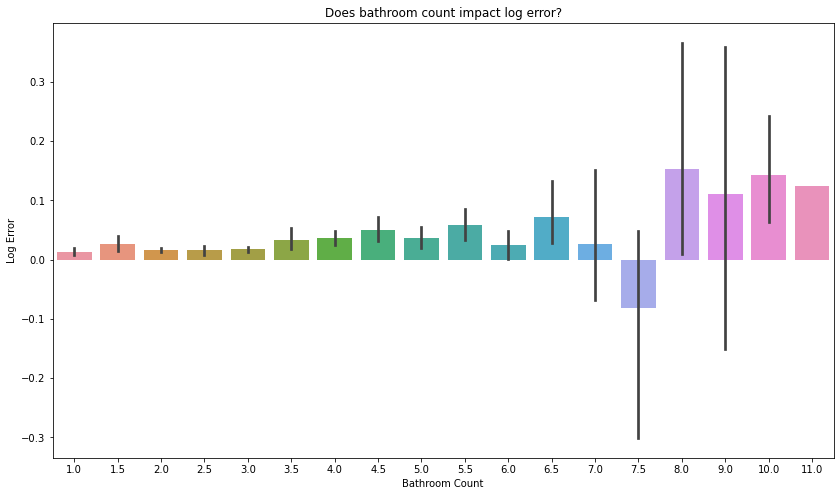

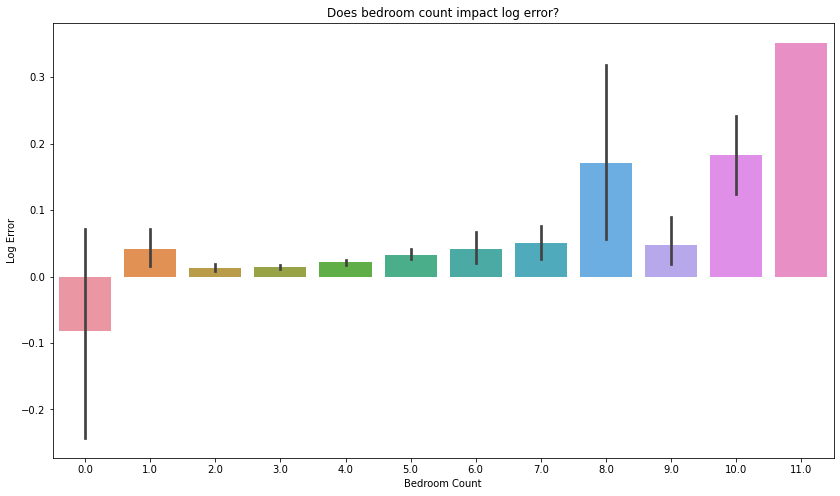

(None, None)

In [9]:
ex.bathroom_viz(train), ex.bedroom_viz(train)

### It seems that as the number of rooms grows for both bedrooms and bathrooms, so does the varience of size with Log Error

we'll perform a pearson test to check for correlations between these two variables

In [10]:
ex.fast_pearson(train.bathroomcnt, train.bedroomcnt)

correlation is 0.6444885883991496
P-value is 0.0
We reject the null hypothesis
we have confidence that there is a correlation


## Clustering

### can we make good clusters from bedrooms and bathrooms?

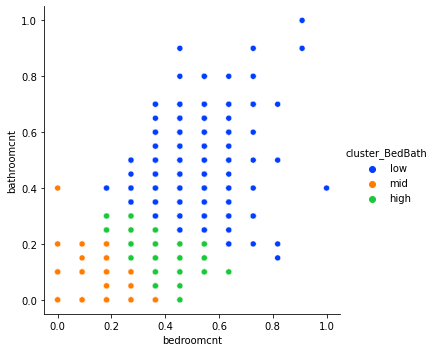

In [11]:
ex.viz_cluster_BedBath(train_scaled)

In [12]:
ex.test_cluster_BedBath(train_scaled)



alpha =  0.05

stat =  24.254052843227505
p =  2.988198029429945e-11

Reject H0, There is a significant difference in logerror among the BedBath clusters.


### there is statistical significance in these clusters and they will be useful in modeling

### Do Bedrooms, Bathrooms, and Square Feet make good clusters?

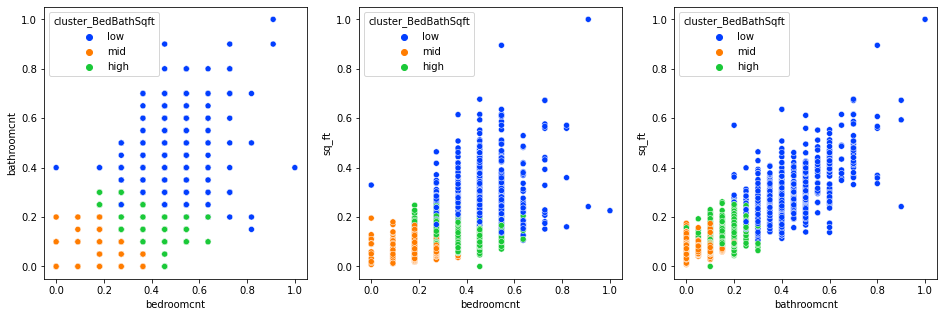

In [13]:
ex.viz_cluster_BedBathSqft(train_scaled)

In [14]:
ex.test_cluster_BedBathSqft(train_scaled)



alpha =  0.05

stat =  25.02320586902465
p =  1.3865572453607754e-11

Reject H0, There is a significant difference in logerror among the BedBathSqft clusters.


### The statistical significance of these clussters is also good

### What is the best number of clusters for Latitude and Longitude?

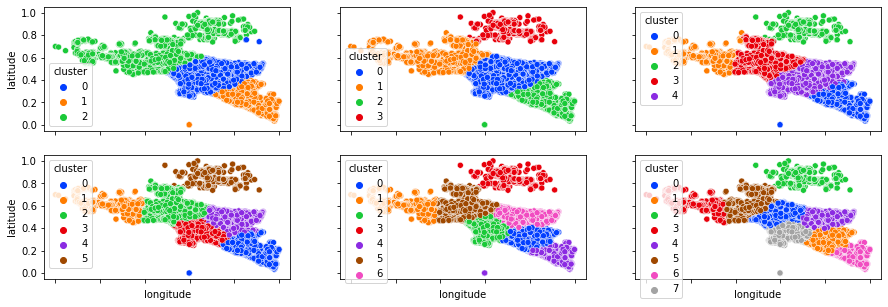

In [15]:
ex.viz_clusters_LatLong(train_scaled)

### visually, n_cluster 4 stands out the most, and after more statistical testing is also shown to have the most statistical ssignificance

In [16]:
ex.test_cluster_LatLong(train_scaled)



alpha =  0.05

stat =  10.425546851254431
p =  7.492522373794879e-07

Reject H0, There is a significant difference in logerror among the LatLong clusters.


## Takeaway:

### All clustering models have enough statistical significance, that I feel comfortable using these as features in modeling

#### one more feature will be included in the model which also had statistical significance:  Bed & Bath with Tax Value per Square Foot.

# Modeling

## X/y split, baseline, and Regression models

In [17]:
#First we'll encode our features, to make them usable in the final model
train_scaled,validate_scaled,test_scaled = wg.dummies(train_scaled,validate_scaled,test_scaled)


In [18]:
train_scaled.head()

,bathroomcnt,bedroomcnt,sq_ft,county,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxdelinquencyflag,logerror,propertylandusedesc,hot_tub_or_spa,age,taxval_sqft,cluster_BedBath,cluster_BedBathSqft,cluster_BedBathTaxvaluepersqft,cluster_LatLong,cluster,cluster_BedBath_low,cluster_BedBath_mid,cluster_BedBathSqft_low,cluster_BedBathSqft_mid,cluster_BedBathTaxvaluepersqft_1,cluster_BedBathTaxvaluepersqft_2,cluster_LatLong_east,cluster_LatLong_north,cluster_LatLong_west
7677,0.4,0.363636,0.162172,LA County,0.0,0.4,0.0,0.000000,0.0,0.551620,0.461458,0.000749,0.0,0.053904,0.036677,1,0.003152,Single Family Residential,0,0.065217,0.067361,low,low,1,central,5,1,0,1,0,1,0,0,0,0
12608,0.1,0.272727,0.078980,LA County,0.0,0.1,0.0,0.000000,0.0,0.777917,0.444821,0.001746,0.0,0.039519,0.015908,0,0.004674,Single Family Residential,0,0.369565,0.056960,mid,mid,0,central,5,0,1,0,1,0,0,0,0,0
44211,0.1,0.272727,0.055461,LA County,0.0,0.1,0.0,0.000000,0.0,0.580396,0.497229,0.000930,0.0,0.029990,0.017907,0,-0.037723,Single Family Residential,0,0.485507,0.088089,mid,mid,0,central,5,0,1,0,1,0,0,0,0,0
44400,0.1,0.272727,0.077810,LA County,0.0,0.1,0.0,0.000000,0.0,0.343542,0.687752,0.000698,0.0,0.015154,0.020441,0,-0.014083,Single Family Residential,0,0.463768,0.074392,mid,mid,0,east,7,0,1,0,1,0,0,1,0,0
30257,0.2,0.363636,0.108348,Orange County,0.0,0.2,0.1,0.134436,0.0,0.300080,0.798239,0.001056,0.0,0.021640,0.017938,0,-0.096859,Single Family Residential,0,0.456522,0.047919,high,high,2,west,1,0,0,0,0,0,1,0,0,1


In [19]:
features = ['cluster_LatLong_west','cluster_LatLong_north','cluster_LatLong_east','cluster_BedBathTaxvaluepersqft_2','cluster_BedBathTaxvaluepersqft_1','cluster_BedBathSqft_mid','cluster_BedBathSqft_low','cluster_BedBath_mid','cluster_BedBath_low']

#Splitting Train Set:
X_train = train_scaled[features]
y_train = train[['logerror']]

#Splitting Validate Set:
X_validate = validate_scaled[features]
y_validate = validate[['logerror']]
#Splitting Test Set:
X_test = test_scaled[features]
y_test = test[['logerror']]

## Baseline model

In [20]:
#Adding mean baseline value to y_train:
y_train['baseline_mean'] = y_train.logerror.mean()
#Adding mean baseline value to y_validate:
y_validate['baseline_mean'] = y_validate.logerror.mean()

## Calculating RMSE

In [21]:
# Creating an empty list for baseline results:
results = []

# Creating a dictionary of baseline mean values:
baseline_mean = {
    'model':'baseline_mean',
    'RMSE_train': mean_squared_error(y_train['logerror'], y_train['baseline_mean']) ** 0.5,
    'RMSE_validate': mean_squared_error(y_validate['logerror'], y_validate['baseline_mean'])** 0.5
}
#Appending baseline mean to results list:
results.append(baseline_mean)

#Creating a DataFrame from the list of result dictionaries:
results = pd.DataFrame(results)
results

,model,RMSE_train,RMSE_validate
0,baseline_mean,0.177254,0.182948


# OLS Model

In [22]:
#Creating an empty list for the error calculations:
error = []

# Creating the Model Object:
lm = LinearRegression(normalize=True)

# Fitting the model to the value in the training set:
lm.fit(X_train, y_train.logerror)

# Using OLS to make predictions on training set:
y_train['OLS_pred'] = lm.predict(X_train)

# Calculating the RMSE for train:
rmse_train = mean_squared_error(y_train.logerror, y_train.OLS_pred)**(0.5)

# Using OLS to make predictions on validate set:
y_validate['OLS_pred'] = lm.predict(X_validate)

# Calculating the RMSE for validate:
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.OLS_pred)**(0.5)

#Creating a dictionary of ols_regression stats:
ols_regression = {
    'model':'ols_regression',
    'RMSE_train': mean_squared_error(y_train['logerror'], y_train['OLS_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['logerror'], y_validate['OLS_pred'])**(0.5)
}

#Adding the ols_regression stats to the empty list:
error.append(ols_regression)
#Converting the list to a DataFrame:
error = pd.DataFrame(error)

#Concatenating the RMSE DataFrames, ignoring index so it auto-updates in the final DataFrame:
results = pd.concat([results, error], ignore_index = True)
results

,model,RMSE_train,RMSE_validate
0,baseline_mean,0.177254,0.182948
1,ols_regression,0.177005,0.182767



# Polynomial regression

## Features

In [23]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree = 3)

# fit and transform X_train_scaled
X_train3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate3 = pf.transform(X_validate)
X_test3 = pf.transform(X_test)

In [24]:
#Creating an empty list for the error calculations:
error = []

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train3, y_train.logerror)

# predict train
y_train['poly_pred'] = lm2.predict(X_train3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.poly_pred) ** 0.5

# predict validate
y_validate['poly_pred'] = lm2.predict(X_validate3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.poly_pred) ** 0.5

#Creating a dictionary of polynomial stats:
polynomial_regressor = {
    'model':'poly_regressor',
    'RMSE_train': mean_squared_error(y_train['logerror'], y_train['poly_pred']) ** (0.5),
    'RMSE_validate': mean_squared_error(y_validate['logerror'], y_validate['poly_pred']) ** (0.5)
}

#Adding the tweedie_regressor stats to the empty list:
error.append(polynomial_regressor)
#Converting the list to a DataFrame:
error = pd.DataFrame(error)

#Concatenating the RMSE DataFrames, ignoring index so it auto-updates in the final DataFrame:
results = pd.concat([results, error], ignore_index = True)
results

,model,RMSE_train,RMSE_validate
0,baseline_mean,0.177254,0.182948
1,ols_regression,0.177005,0.182767
2,poly_regressor,0.176954,0.182790


# Lasso Lars

In [25]:
#Creating an empty list for the error calculations:
error = []

# Creating the Model Object:
lars = LassoLars(alpha=1)

# Fitting the model object to the training set:
lars.fit(X_train, y_train.logerror)

# Using the LassoLars model to make predictions on the training set:
y_train['lasso_pred'] = lars.predict(X_train)

# Calculating the RMSE for the training set:
rmse_train = mean_squared_error(y_train.logerror, y_train.lasso_pred) ** (0.5)

# Using the LassoLars model to make predictions on the validate set:
y_validate['lasso_pred'] = lars.predict(X_validate)

# Calculating the RMSE for the validate set:
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.lasso_pred) ** (0.5)

#Creating a dictionary of LassoLars stats:
lasso_lars = {
    'model':'LassoLars',
    'RMSE_train': mean_squared_error(y_train['logerror'], y_train['lasso_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['logerror'], y_validate['lasso_pred'])**(0.5)
}


#Adding the lasso_lars stats to the empty list:
error.append(lasso_lars)
#Converting the list to a DataFrame:
error = pd.DataFrame(error)

#Concatenating the RMSE DataFrames, ignoring index so it auto-updates in the final DataFrame:
results = pd.concat([results, error], ignore_index = True)
results

,model,RMSE_train,RMSE_validate
0,baseline_mean,0.177254,0.182948
1,ols_regression,0.177005,0.182767
2,poly_regressor,0.176954,0.182790
3,LassoLars,0.177254,0.182949


# Lasso Lars: Test

In [26]:
#Creating an empty list for the error calculations:
error = []

# Creating the Model Object:
lars = LassoLars(alpha=1)

# Fitting the model object to the training set:
lars.fit(X_train, y_train.logerror)

# Using the LassoLars model to make predictions on the training set:
y_train['lasso_pred'] = lars.predict(X_train)

# Calculating the RMSE for the training set:
rmse_train = mean_squared_error(y_train.logerror, y_train.lasso_pred) ** (0.5)

# Using the LassoLars model to make predictions on the validate set:
y_test['lasso_pred'] = lars.predict(X_test)

# Calculating the RMSE for the validate set:
rmse_validate = mean_squared_error(y_test.logerror, y_test.lasso_pred) ** (0.5)

#Creating a dictionary of LassoLars stats:
lasso_lars = {
    'model':'LassoLars',
    'RMSE_train': mean_squared_error(y_train['logerror'], y_train['lasso_pred'])**(0.5),
    'RMSE_test': mean_squared_error(y_test['logerror'], y_test['lasso_pred'])**(0.5)
}


#Adding the lasso_lars stats to the empty list:
error.append(lasso_lars)
#Converting the list to a DataFrame:
error = pd.DataFrame(error)

#Concatenating the RMSE DataFrames, ignoring index so it auto-updates in the final DataFrame:
results = pd.concat([results, error], ignore_index = True)
results

,model,RMSE_train,RMSE_validate,RMSE_test
0,baseline_mean,0.177254,0.182948,NaN
1,ols_regression,0.177005,0.182767,NaN
2,poly_regressor,0.176954,0.182790,NaN
3,LassoLars,0.177254,0.182949,NaN
4,LassoLars,0.177254,NaN,0.157919


In [27]:
test_performance = (results.RMSE_validate[0] - results.RMSE_test[4]) / results.RMSE_validate[0]
print(f"The model beats the baseline by {round((test_performance * 100),2)}%.")

The model beats the baseline by 13.68%.


# Conclusion:

## Takeaway:

- while we were able to find some correlations to the target variable, over all they were not very large.

- Bedrroms, Bathrooms, Square Footage, Lat & long, and Tax Valuation seemed to be the larrgest driver of this particular dataset.

- 13% increase is a good start, and with more time I'm certain we could increase that number.

## Recomendations:

- As the model is currently better than the baseline I wouldd recommend implementation until a better model can be realized.

## Next Steps?

- more feature engineering.

- Find a method to handle outliers.

- _And/Or_ convert MinMaxscaler to a robust scaling model.